In [1]:
import os

os.environ["PYSYN_CDBS"] = "/home/ruizhew/POSEIDON/inputs/stellar_grids/"
os.environ["POSEIDON_input_data"] = "/home/ruizhew/POSEIDON/inputs/"

In [2]:
from __future__ import absolute_import, unicode_literals, print_function
from POSEIDON.high_res import (
    fast_filter,
    loglikelihood_sysrem,
    get_rot_kernel,
    fit_uncertainties,
    fit_uncertainties_and_remove_outliers,
)
import math, os
import numpy as np
import pickle
import pickle
from scipy import constants
from numba import jit
from astropy.io import fits
from scipy import interpolate
from POSEIDON.core import (
    create_star,
    create_planet,
    define_model,
    make_atmosphere,
    read_opacities,
    wl_grid_constant_R,
    wl_grid_line_by_line,
    compute_spectrum,
)
from POSEIDON.constants import R_Sun
from POSEIDON.visuals import plot_stellar_flux
from POSEIDON.constants import R_J, M_J
import numpy as np
from spectres import spectres
from tqdm import tqdm
from multiprocessing import Pool
import h5py
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d, median_filter

In [3]:
from scipy.optimize import minimize
from sklearn.decomposition import TruncatedSVD

In [4]:
# data = h5py.File("./data/WASP-76b.h5", "a")

In [5]:
# wl_grid, data_raw = pickle.load(
#     open("../high_res_experiments/data/WASP-76b-MAROON/night_1/data_raw.pic", "rb")
# )
wl_grid, data_arr = pickle.load(
    open("../high_res_experiments/data/WASP-77Ab/data_arr.pic", "rb")
)
wl_grid, data_scale = pickle.load(
    open("../high_res_experiments/data/WASP-77Ab/data_scale.pic", "rb")
)
V_bary = pickle.load(open("../high_res_experiments/data/WASP-77Ab/V_bary.pic", "rb"))

In [6]:
data_raw = data_arr + data_scale

In [7]:
from POSEIDON.core import create_star
from POSEIDON.constants import R_Sun, R_J, M_J

# ***** Define stellar properties *****#
# R_s = 1.756 * R_Sun  # Stellar radius (m)
# T_s = 6250  # Stellar effective temperature (K)
# Met_s = 0.23  # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
# log_g_s = 4.13  # Stellar log surface gravity (log10(cm/s^2) by convention)

# WASP-77Ab:
R_s = 1.21 * R_Sun  # Stellar radius (m)
T_s = 5605.0  # Stellar effective temperature (K)
Met_s = -0.04  # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.56  # Stellar log surface gravity (log10(cm/s^2) by convention)

wl_min = 2.3
wl_max = 2.5
step = 1e-6
wl = np.arange(wl_min, wl_max, step)
# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s, wl=wl, stellar_grid="phoenix")
F_star = star["F_star"]
wl_star = star["wl_star"]

In [8]:
F_s_continuum = gaussian_filter1d(median_filter(F_star, 10000), 10000)

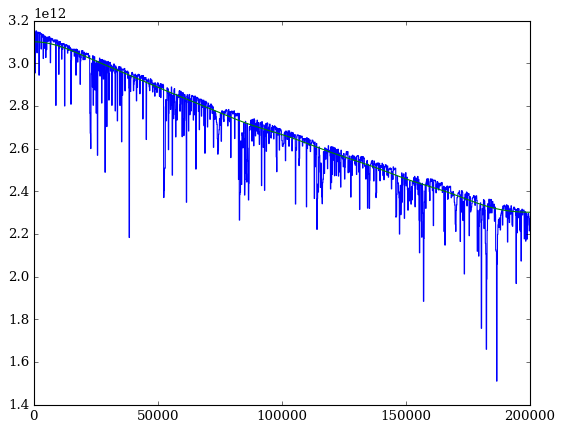

In [9]:
plt.plot(F_star)
plt.plot(F_s_continuum)

In [23]:
a = F_star / F_s_continuum
a[a > 1] = 1

In [30]:
order_i = 4
phi_i = 0
wl_grid_const = np.arange(wl_grid[order_i].min(), wl_grid[order_i].max(), step)
F_p = np.interp(wl_grid_const, wl_grid[order_i], data_raw[order_i][phi_i])
F_p_continuum = gaussian_filter1d(median_filter(F_p, 4000), 100)
b = F_p / F_p_continuum
b[b > 1] = 1

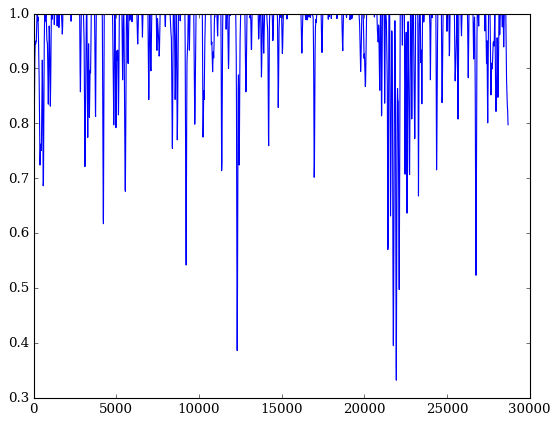

In [31]:
plt.plot(b)

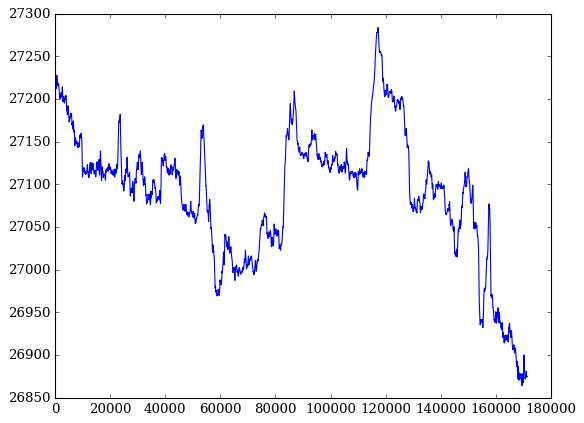

In [32]:
res = np.correlate(a, b, mode="valid")
plt.plot(res)

In [33]:
wl_star[np.argmax(res)]

2.417286000016394

In [34]:
wl_grid_const.min()

2.2952041378853707

In [ ]:
for phi_i in range(data_raw.shape[1]):
    wl_grid_const = np.arange(wl_grid[order_i].min(), wl_grid[order_i].max(), step)
    F_p = np.interp(wl_grid_const, wl_grid[order_i], data_raw[order_i][phi_i])
    F_p_continuum = gaussian_filter1d(median_filter(F_p, 100), 100)
    res = np.correlate(F_star - F_s_continuum, F_p - F_p_continuum, mode="valid")
    RVs = np.arange(-100, 100, 1)

    print(
        RVs[
            np.array(
                [
                    abs(
                        wl_star[np.argmax(res)] * (1.0 + RV * 1e3 / constants.c)
                        - wl_grid_const.min()
                    )
                    for RV in RVs
                ]
            ).argmin()
        ]
    )